In [15]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import our custom analysis frameworks
from explainability_analysis import ExplainabilityAnalyzer, clear_memory, save_intermediate_results,load_intermediate_results
from enhanced_evaluation import ComprehensiveEvaluator
from ablation_studies import AblationStudyAnalyzer
from enhanced_ablation_studies import run_enhanced_ablation_studies, load_model_ablation_results

# Memory management utilities
import gc
import pickle
import os
import xgboost as xgb

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

import logging
import sys
from datetime import datetime

# Configure logging to file
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('Ablation.log'),
        logging.StreamHandler(sys.stdout)  # Also print to console
    ]
)

# Usage
logging.info("This will be written to Ablation.log")
logging.error("Error messages too")


print("🔍 Section 5: Ablation Studies")
print("Dataset: Online Shoppers Purchasing Intention")

🔍 Section 5: Ablation Studies
Dataset: Online Shoppers Purchasing Intention


In [16]:
# Load trained models and results from Section 2
try:
    with open('./online_shoppers_section2_results.pkl', 'rb') as f:
        section2_data = pickle.load(f)

    # Extract variables
    models = section2_data['models']
    evaluator = section2_data['evaluator']
    X_train_scaled = section2_data['X_train_scaled']
    X_val_scaled = section2_data['X_val_scaled']
    X_test_scaled = section2_data['X_test_scaled']
    y_train = section2_data['y_train']
    y_val = section2_data['y_val']
    y_test = section2_data['y_test']
    feature_names = section2_data['feature_names']
    month_mapping = section2_data['month_mapping']
    visitor_mapping = section2_data['visitor_mapping']
    class_names = section2_data['class_names']
    label_encoder_month = section2_data['label_encoder_month']
    label_encoder_visitor = section2_data['label_encoder_visitor']
    scaler = section2_data['scaler']
    data_summary = section2_data['data_summary']
    comparison_df = section2_data['comparison_df']

    print("✅ Section 2 results loaded successfully!")
    print(f"Models available: {list(models.keys())}")
    print(f"Features: {len(feature_names)}")
    print(f"Classes: {len(class_names)}")
    print(f"Test samples: {len(X_test_scaled):,}")
    
    # Display feature names for reference
    print(f"\n📋 Feature Names:")
    for i, feature in enumerate(feature_names):
        print(f"   {i+1:2d}. {feature}")

except FileNotFoundError:
    print("❌ Section 2 results not found!")
    print("Please run Section 2 (Model Training) notebook first.")
    raise

✅ Section 2 results loaded successfully!
Models available: ['XGBoost', 'TabPFN v2', 'TabICL', 'FT-Transformer']
Features: 17
Classes: 2
Test samples: 2,466

📋 Feature Names:
    1. Administrative
    2. Administrative_Duration
    3. Informational
    4. Informational_Duration
    5. ProductRelated
    6. ProductRelated_Duration
    7. BounceRates
    8. ExitRates
    9. PageValues
   10. SpecialDay
   11. Month
   12. OperatingSystems
   13. Browser
   14. Region
   15. TrafficType
   16. VisitorType
   17. Weekend


In [17]:
# create FT- Pytorch wrappper
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
original_ft_transfomer= models['FT-Transformer']
ft_wrapper = evaluator.create_pytorch_wrapper(
            model=original_ft_transfomer,
            device=device,
            batch_size=256
        )

#for the ablation studies
models['FT-Transformer'] = ft_wrapper

# Enhanced Ablation Studies Integration

In [18]:
# Initialize ablation study analyzer
ablation_analyzer = AblationStudyAnalyzer()

print("\n" + "="*60)
print("ABLATION STUDIES")
print("="*60)


ABLATION STUDIES



🔬 Feature Ablation Study for XGBoost
📊 Baseline Performance (All Features):
   Accuracy: 0.8974
   F1-Score: 0.6307
   AUC: 0.9212

🔍 Single Feature Removal Analysis...

🎯 Top 5 Most Important Features (by F1 drop when removed):
   1. PageValues: F1 drop = 0.3721
   2. Month: F1 drop = 0.0268
   3. Region: F1 drop = 0.0064
   4. TrafficType: F1 drop = 0.0039
   5. Weekend: F1 drop = 0.0037

🔍 Multiple Feature Removal Analysis...
   Testing removal of 2 features...
   Testing removal of 3 features...

🔍 Feature Group Removal Analysis...

🎯 Feature Group Importance (by F1 drop when removed):
   1. Behavior_Metrics: F1 drop = 0.4106
   2. Temporal: F1 drop = 0.0144
   3. Administrative: F1 drop = 0.0102
   4. Technical: F1 drop = 0.0067
   5. ProductRelated: F1 drop = -0.0014
   6. Informational: F1 drop = -0.0089
   7. User_Type: F1 drop = -0.0136


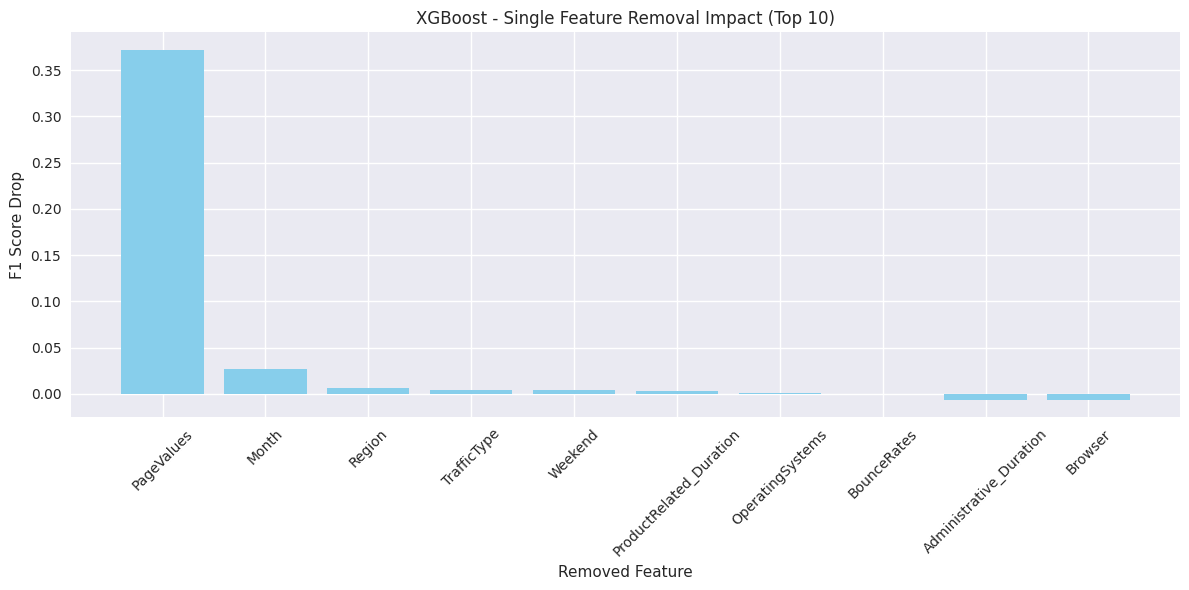

<Figure size 800x550 with 0 Axes>

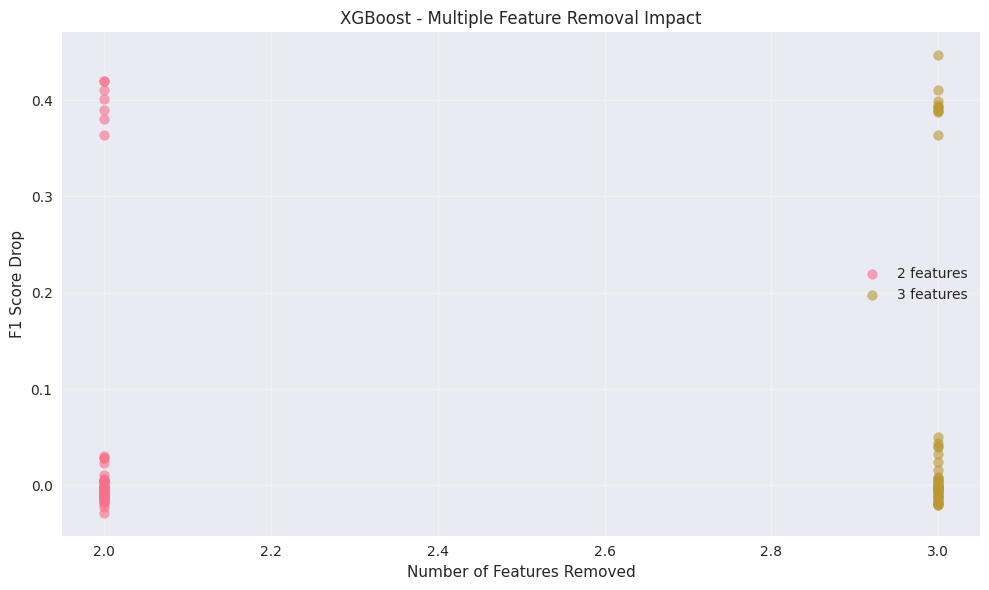

<Figure size 800x550 with 0 Axes>

In [9]:
# Feature ablation study for XGBoost
xgb_ablation = ablation_analyzer.feature_ablation_study(
    models['XGBoost'], "XGBoost",
    X_train_scaled, X_test_scaled, y_train, y_test,
    feature_names=feature_names,
    max_features_to_remove=3
)


⚙️  Hyperparameter Ablation Study for XGBoost
📊 Baseline F1 Score (default params): 0.6291
🔍 Searching hyperparameter space...
🎯 Best F1 Score: 0.6372
📈 Improvement: 0.0081
🔧 Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


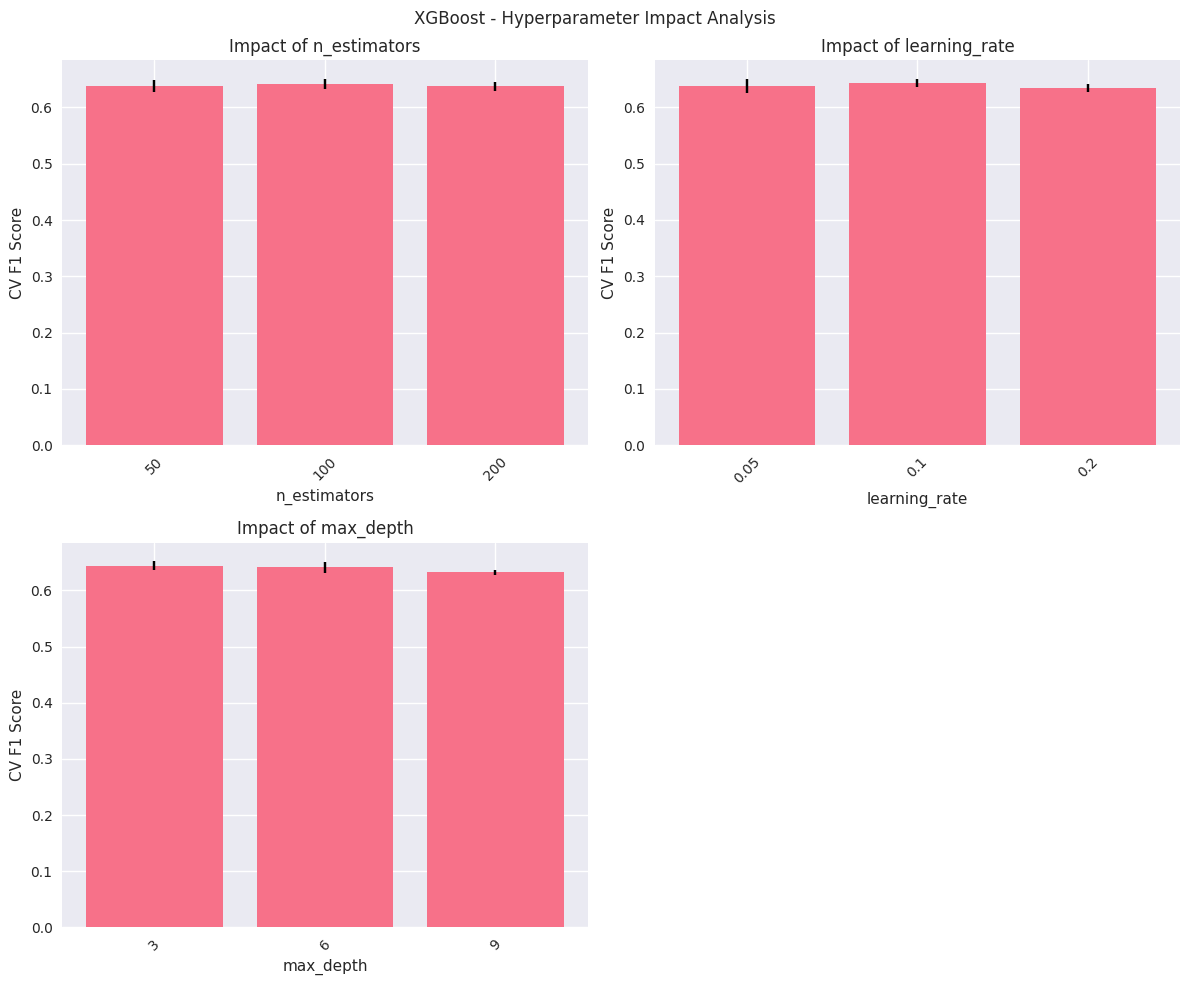

<Figure size 800x550 with 0 Axes>

In [10]:
# Hyperparameter ablation study for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}

xgb_hyperparam_ablation = ablation_analyzer.hyperparameter_ablation_study(
    xgb.XGBClassifier, "XGBoost",
    X_train_scaled, X_test_scaled, y_train, y_test,
    xgb_param_grid, cv_folds=3
)


📊 Data Size Ablation Study for XGBoost
    10% data: F1 = 0.5867, Time = 0.09s
    20% data: F1 = 0.5867, Time = 0.10s
    30% data: F1 = 0.6186, Time = 0.12s
    50% data: F1 = 0.6104, Time = 0.14s
    70% data: F1 = 0.6181, Time = 0.16s
    90% data: F1 = 0.6505, Time = 0.16s
   100% data: F1 = 0.6368, Time = 0.17s


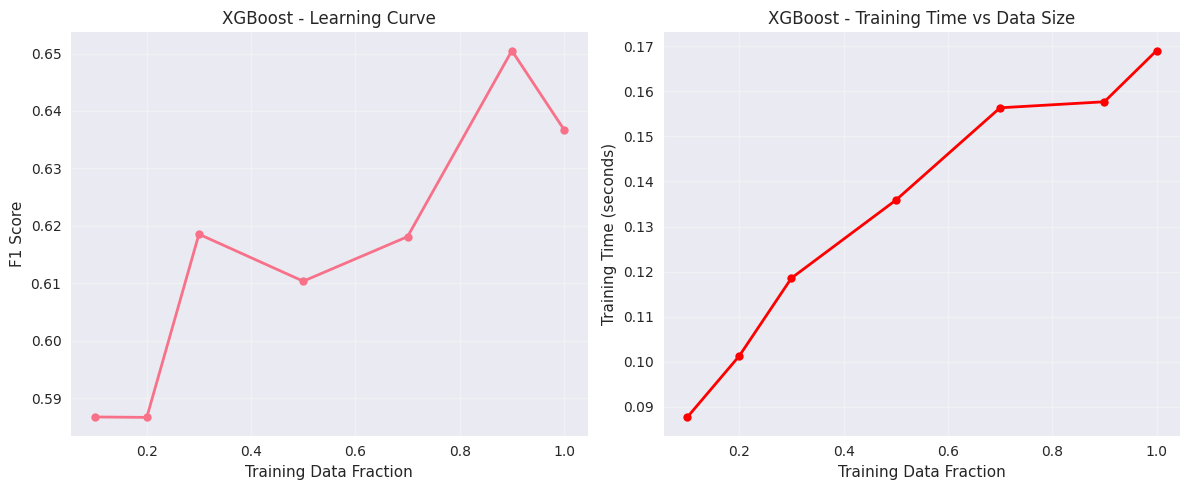

<Figure size 800x550 with 0 Axes>

In [11]:
# Data size ablation study
xgb_data_ablation = ablation_analyzer.data_size_ablation_study(
    models['XGBoost'], "XGBoost",
    X_train_scaled, X_test_scaled, y_train, y_test,
    size_fractions=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0]
)

In [12]:
# Generate ablation report
ablation_analyzer.generate_ablation_report("XGBoost")


📋 Ablation Study Report for XGBoost

📊 Baseline Performance:
   Accuracy: 0.8974
   F1-Score: 0.6307
   AUC: 0.9212

🎯 Most Critical Individual Features:
   1. PageValues: F1 drop = 0.3721
   2. Month: F1 drop = 0.0268
   3. Region: F1 drop = 0.0064

🎯 Most Critical Feature Groups:
   1. Behavior_Metrics: F1 drop = 0.4106
   2. Temporal: F1 drop = 0.0144
   3. Administrative: F1 drop = 0.0102

✅ Ablation study analysis complete for XGBoost




## Advanced TabICL and TabPFN Ablation Analysis

This notebook integrates enhanced ablation studies for TabICL and TabPFN models, building upon the comprehensive comparison analysis. It assumes that the following are already available from the comprehensive comparison notebook:

- **Preprocessed Data**: `X_train_scaled`, `X_test_scaled`, `y_train`, `y_test`, `feature_names`
- **Trained Models**: `models` dictionary containing XGBoost, TabPFN v2, and TabICL
- **Model Names**: `model_names` list

### Enhanced Ablation Studies Include:
- **TabPFN-Specific**: Context size optimization, device performance, memory efficiency
- **TabICL-Specific**: In-context learning examples, example selection strategies, context window utilization
- **Cross-Model Analysis**: Feature importance comparison, robustness analysis
- **Production Insights**: Performance recommendations and deployment considerations

## Import Enhanced Ablation Framework

In [19]:
# Import enhanced ablation studies framework
from enhanced_ablation_studies import (
    EnhancedAblationStudyAnalyzer, 
    run_enhanced_ablation_studies,
    create_ablation_summary_dataframe,
    plot_ablation_dashboard
)

print("🔬 Enhanced Ablation Studies Framework Loaded")
print("Ready to perform advanced ablation analysis on TabICL and TabPFN models")

🔬 Enhanced Ablation Studies Framework Loaded
Ready to perform advanced ablation analysis on TabICL and TabPFN models


## Verify Available Resources

Let's confirm that all required resources from the comprehensive comparison are available.

In [20]:
# Verify that required variables are available from comprehensive comparison notebook
required_vars = [
    'X_train_scaled', 'X_test_scaled', 'y_train', 'y_test', 
    'feature_names', 'models', 'model_names'
]

model_names= models.keys()
import os
os.environ['TABPFN_ALLOW_CPU_LARGE_DATASET'] = '1'
print("🔍 Verifying Required Resources:")
for var_name in required_vars:
    if var_name in globals():
        if var_name == 'models':
            print(f"   ✅ {var_name}: {list(models.keys())}")
        elif var_name in ['X_train_scaled', 'X_test_scaled']:
            print(f"   ✅ {var_name}: shape {globals()[var_name].shape}")
        elif var_name in ['y_train', 'y_test']:
            print(f"   ✅ {var_name}: length {len(globals()[var_name])}")
        elif var_name == 'feature_names':
            print(f"   ✅ {var_name}: {len(feature_names)} features")
        else:
            print(f"   ✅ {var_name}: available")
    else:
        print(f"   ❌ {var_name}: NOT FOUND - Please run comprehensive comparison notebook first")

print(f"\n📊 Models available for enhanced ablation studies: {model_names}")

🔍 Verifying Required Resources:
   ✅ X_train_scaled: shape (7891, 17)
   ✅ X_test_scaled: shape (2466, 17)
   ✅ y_train: length 7891
   ✅ y_test: length 2466
   ✅ feature_names: 17 features
   ✅ models: ['XGBoost', 'TabPFN v2', 'TabICL', 'FT-Transformer']
   ✅ model_names: available

📊 Models available for enhanced ablation studies: dict_keys(['XGBoost', 'TabPFN v2', 'TabICL', 'FT-Transformer'])


## Initialize Enhanced Ablation Studies

Now we'll run the comprehensive enhanced ablation studies specifically designed for TabICL and TabPFN.

In [6]:
# Initialize enhanced ablation study analyzer
print("🚀 INITIALIZING ENHANCED ABLATION STUDIES")
print("=" * 80)

enhanced_analyzer = EnhancedAblationStudyAnalyzer()

🚀 INITIALIZING ENHANCED ABLATION STUDIES


In [39]:


# Run comprehensive ablation studies
print("\n🔬 Starting enhanced ablation analysis...")
print("This will perform model-specific ablations for TabICL and TabPFN")
print("Expected duration: 5-15 minutes depending on hardware")

enhanced_ablation_results = enhanced_analyzer.comprehensive_ablation_study(
    models_dict=models,
    model_names=model_names,
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train,
    y_test=y_test,
    feature_names=feature_names
)


🔬 Starting enhanced ablation analysis...
This will perform model-specific ablations for TabICL and TabPFN
Expected duration: 5-15 minutes depending on hardware
🔬 COMPREHENSIVE ABLATION STUDY

📊 Running ablation studies for XGBoost...
      🔍 Feature ablation study...
      📊 Data size ablation study...
      🔊 Noise robustness study...
   🧪 Running XGBoost-specific ablations...
        🎛️ Hyperparameter ablation...
        🌳 Tree complexity ablation...
        🛡️ Regularization ablation...
        🎯 Feature importance analysis...
💾 XGBoost ablation results saved to 'online_shoppers_ablation_XGBoost.pkl'

📊 Running ablation studies for TabPFN v2...


KeyboardInterrupt: 

## Enhanced Ablation Results Summary

In [ ]:
# Create comprehensive summary
ablation_summary_df = create_ablation_summary_dataframe(enhanced_ablation_results)

print("\n📊 ENHANCED ABLATION STUDY SUMMARY")
print("=" * 80)
print(ablation_summary_df.round(4).to_string())

# Save results for further analysis
ablation_summary_df.to_csv('enhanced_ablation_summary.csv', index=False)
print("\n💾 Results saved to 'enhanced_ablation_summary.csv'")

## Comprehensive Ablation Dashboard

In [7]:
#temp = load_model_ablation_results('XGBoost')

#enhanced_analyzer.results[temp['model_name']] = temp['results']

#temp = load_model_ablation_results('FT-Transformer')

#enhanced_analyzer.results[temp['model_name']] = temp['results']

#temp = load_model_ablation_results('TabICL')

#enhanced_analyzer.results[temp['model_name']] = temp['results']

#temp = load_model_ablation_results('TabPFN v2')

#enhanced_analyzer.results[temp['model_name']] = temp['results']
#print(enhanced_analyzer.results)

{'XGBoost': {'baseline': {'accuracy': 0.897404703974047, 'f1': 0.6306569343065693, 'precision': 0.7128712871287128, 'recall': 0.5654450261780105, 'auc': 0.9212499120700224, 'train_time': 0.20159173011779785, 'inference_time': 0.0038819313049316406, 'n_train_samples': 7891, 'n_test_samples': 2466}, 'feature_ablation': {'single_feature_removal': [{'removed_feature': 'PageValues', 'removed_feature_idx': 8, 'f1_score': 0.2585551330798479, 'f1_drop': 0.37210180122672143, 'relative_importance': 0.5900225320377411}, {'removed_feature': 'Month', 'removed_feature_idx': 10, 'f1_score': 0.6038291605301914, 'f1_drop': 0.026827773776377906, 'relative_importance': 0.04253940980745108}, {'removed_feature': 'Region', 'removed_feature_idx': 13, 'f1_score': 0.624277456647399, 'f1_drop': 0.006379477659170352, 'relative_importance': 0.010115606936415951}, {'removed_feature': 'TrafficType', 'removed_feature_idx': 14, 'f1_score': 0.6267806267806267, 'f1_drop': 0.0038763075259425905, 'relative_importance': 0

dict_keys(['XGBoost', 'TabPFN v2', 'TabICL', 'FT-Transformer'])
{'XGBoost': {'baseline': {'accuracy': 0.897404703974047, 'f1': 0.6306569343065693, 'precision': 0.7128712871287128, 'recall': 0.5654450261780105, 'auc': 0.9212499120700224, 'train_time': 0.20159173011779785, 'inference_time': 0.0038819313049316406, 'n_train_samples': 7891, 'n_test_samples': 2466}, 'feature_ablation': {'single_feature_removal': [{'removed_feature': 'PageValues', 'removed_feature_idx': 8, 'f1_score': 0.2585551330798479, 'f1_drop': 0.37210180122672143, 'relative_importance': 0.5900225320377411}, {'removed_feature': 'Month', 'removed_feature_idx': 10, 'f1_score': 0.6038291605301914, 'f1_drop': 0.026827773776377906, 'relative_importance': 0.04253940980745108}, {'removed_feature': 'Region', 'removed_feature_idx': 13, 'f1_score': 0.624277456647399, 'f1_drop': 0.006379477659170352, 'relative_importance': 0.010115606936415951}, {'removed_feature': 'TrafficType', 'removed_feature_idx': 14, 'f1_score': 0.626780626780

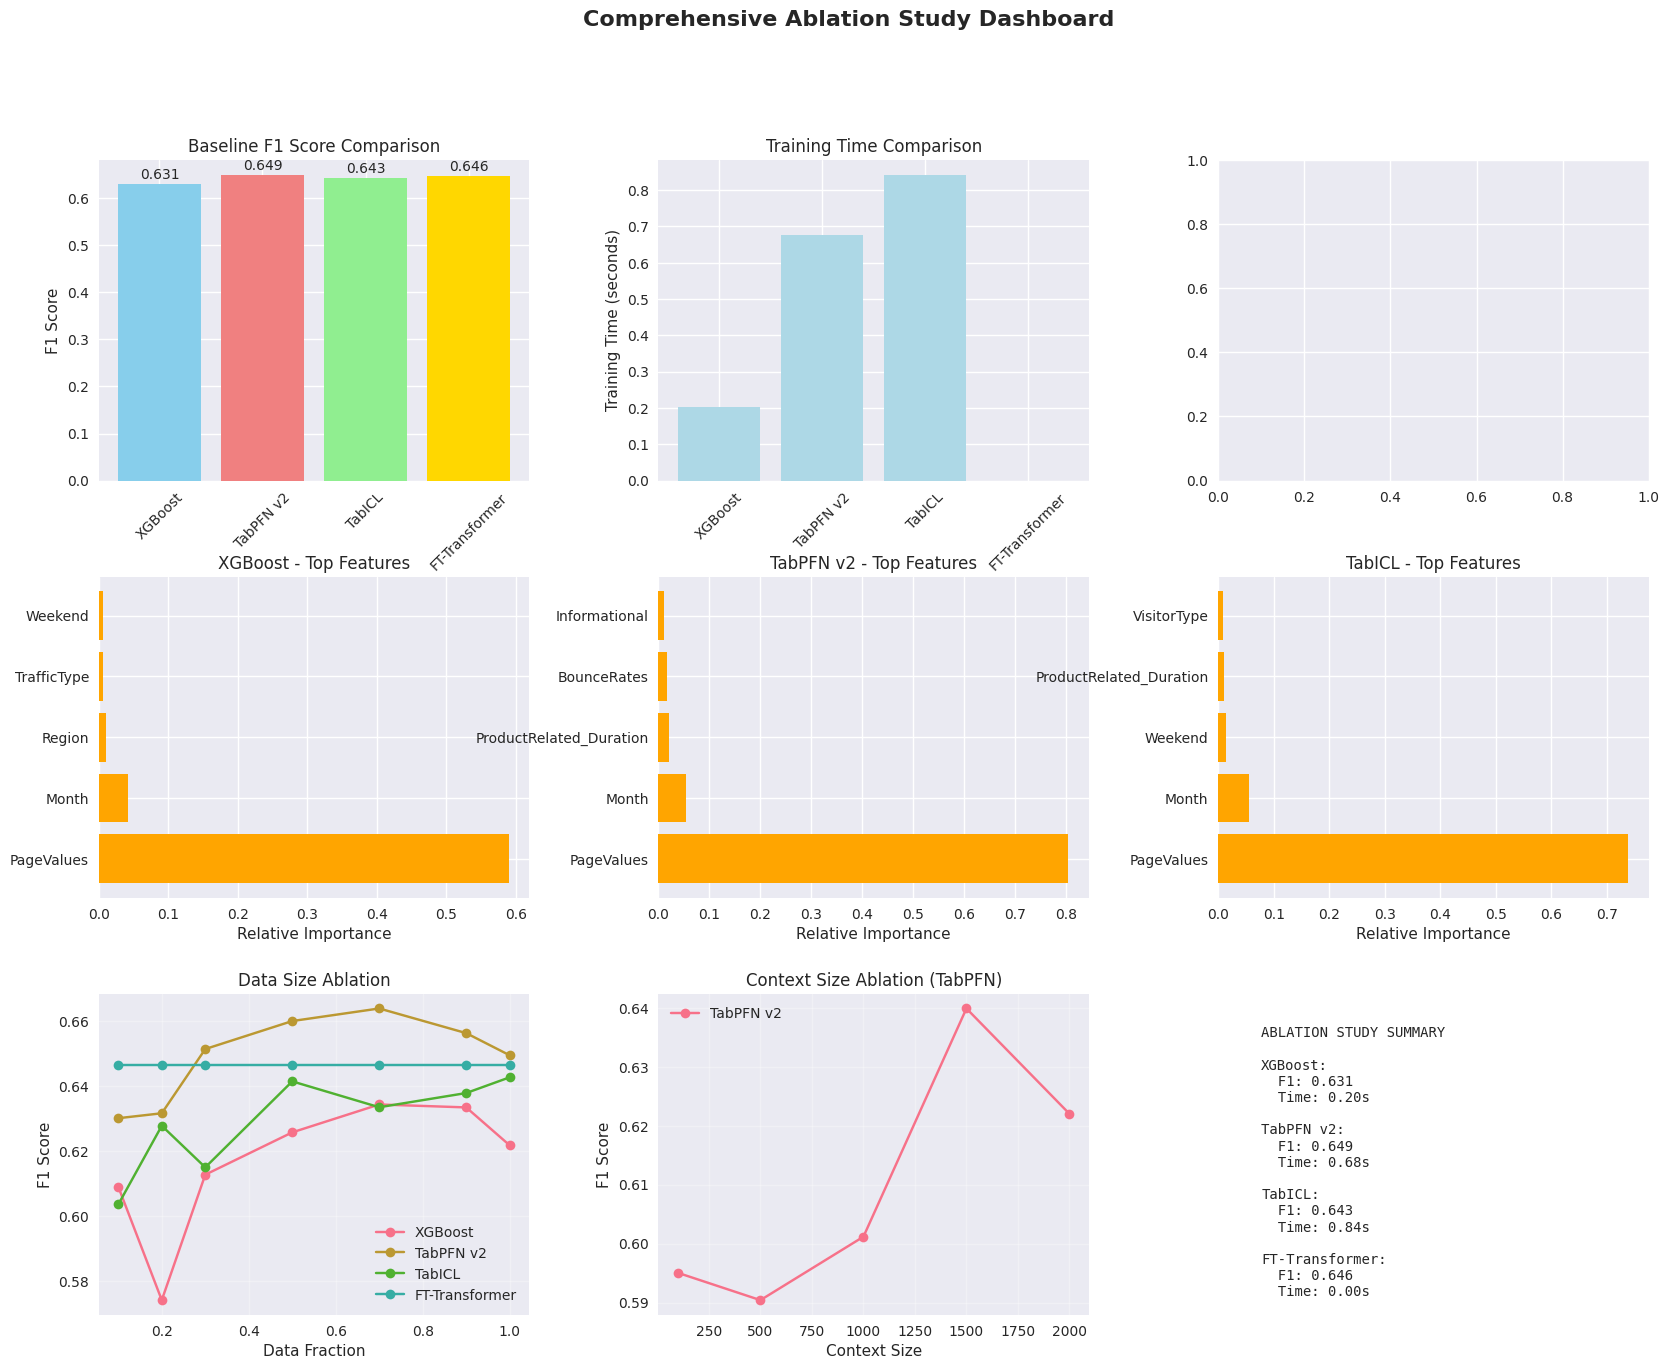

In [8]:

# enhanced_analyzer.results['XGBoost']
# Generate comprehensive dashboard
print("📈 Generating Enhanced Ablation Dashboard...")
plot_ablation_dashboard(enhanced_analyzer, model_names)

## TabPFN-Specific Enhanced Ablations

Deep dive into TabPFN-specific ablation studies including context size optimization, device performance analysis, and memory efficiency testing.


🔬 TABPFN ENHANCED ABLATION ANALYSIS

📏 Context Size Optimization Results:
   context_size  actual_samples  f1_score  accuracy  train_time
0           100             100    0.5950    0.8808      0.1183
1           500             500    0.5904    0.8925      0.1610
2          1000            1000    0.6012    0.8897      0.1822
3          1500            1500    0.6399    0.8946      0.2154
4          2000            2000    0.6220    0.8970      0.2476


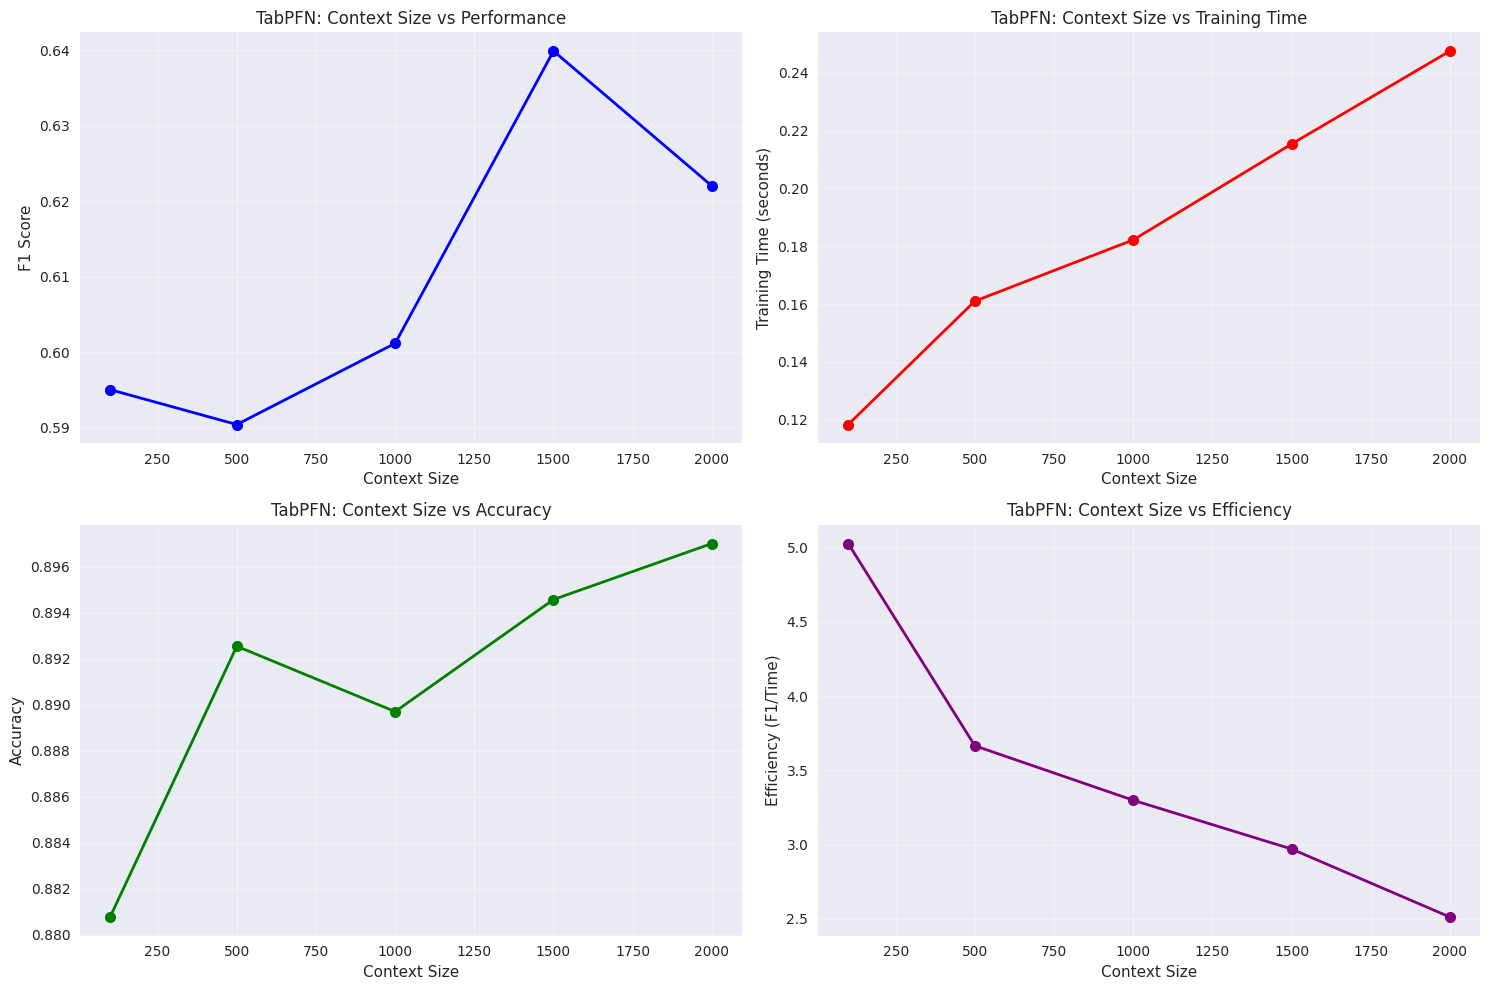


🎯 TabPFN Context Size Insights:
   Optimal for F1: Context size 1500 (F1: 0.6399)
   Optimal for Efficiency: Context size 100 (Efficiency: 5.0282)
   Performance Range: 0.5904 - 0.6399
   Time Range: 0.12s - 0.25s


<Figure size 800x550 with 0 Axes>

In [10]:
# TabPFN-specific analysis
# enhanced_ablation_results = enhanced_analyzer.results
if 'TabPFN v2' in enhanced_ablation_results:
    tabpfn_results = enhanced_ablation_results['TabPFN v2']
    
    print("\n🔬 TABPFN ENHANCED ABLATION ANALYSIS")
    print("=" * 80)
    
    # Context Size Optimization
    if 'context_size_ablation' in tabpfn_results:
        context_results = tabpfn_results['context_size_ablation']
        
        print("\n📏 Context Size Optimization Results:")
        context_df = pd.DataFrame(context_results)
        print(context_df.round(4).to_string())
        
        # Visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Performance vs Context Size
        ax1.plot(context_df['context_size'], context_df['f1_score'], 'o-', linewidth=2, markersize=8, color='blue')
        ax1.set_xlabel('Context Size')
        ax1.set_ylabel('F1 Score')
        ax1.set_title('TabPFN: Context Size vs Performance')
        ax1.grid(True, alpha=0.3)
        
        # Training Time vs Context Size
        ax2.plot(context_df['context_size'], context_df['train_time'], 'o-', linewidth=2, markersize=8, color='red')
        ax2.set_xlabel('Context Size')
        ax2.set_ylabel('Training Time (seconds)')
        ax2.set_title('TabPFN: Context Size vs Training Time')
        ax2.grid(True, alpha=0.3)
        
        # Accuracy vs Context Size
        ax3.plot(context_df['context_size'], context_df['accuracy'], 'o-', linewidth=2, markersize=8, color='green')
        ax3.set_xlabel('Context Size')
        ax3.set_ylabel('Accuracy')
        ax3.set_title('TabPFN: Context Size vs Accuracy')
        ax3.grid(True, alpha=0.3)
        
        # Efficiency (Performance/Time)
        efficiency = context_df['f1_score'] / context_df['train_time']
        ax4.plot(context_df['context_size'], efficiency, 'o-', linewidth=2, markersize=8, color='purple')
        ax4.set_xlabel('Context Size')
        ax4.set_ylabel('Efficiency (F1/Time)')
        ax4.set_title('TabPFN: Context Size vs Efficiency')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('TabPFN_Ablation_Results.png')
        plt.show()
       
        
        # Optimal context size analysis
        best_f1_idx = context_df['f1_score'].idxmax()
        best_efficiency_idx = efficiency.idxmax()
        
        print(f"\n🎯 TabPFN Context Size Insights:")
        print(f"   Optimal for F1: Context size {context_df.loc[best_f1_idx, 'context_size']} (F1: {context_df.loc[best_f1_idx, 'f1_score']:.4f})")
        print(f"   Optimal for Efficiency: Context size {context_df.loc[best_efficiency_idx, 'context_size']} (Efficiency: {efficiency.iloc[best_efficiency_idx]:.4f})")
        print(f"   Performance Range: {context_df['f1_score'].min():.4f} - {context_df['f1_score'].max():.4f}")
        print(f"   Time Range: {context_df['train_time'].min():.2f}s - {context_df['train_time'].max():.2f}s")

## TabICL-Specific Enhanced Ablations

Comprehensive analysis of TabICL's in-context learning capabilities, including context examples optimization, example selection strategies, and context window utilization.


🎯 TABICL ENHANCED ABLATION ANALYSIS

📝 Context Examples Optimization Results:
   context_examples  actual_examples  f1_score  accuracy  train_time
0                16               16    0.0000    0.8451      0.3919
1                32               32    0.0460    0.8487      0.3950
2                64               64    0.4297    0.8569      0.3942
3               128              128    0.3643    0.8670      0.3962
4               256              256    0.5686    0.8942      0.3971


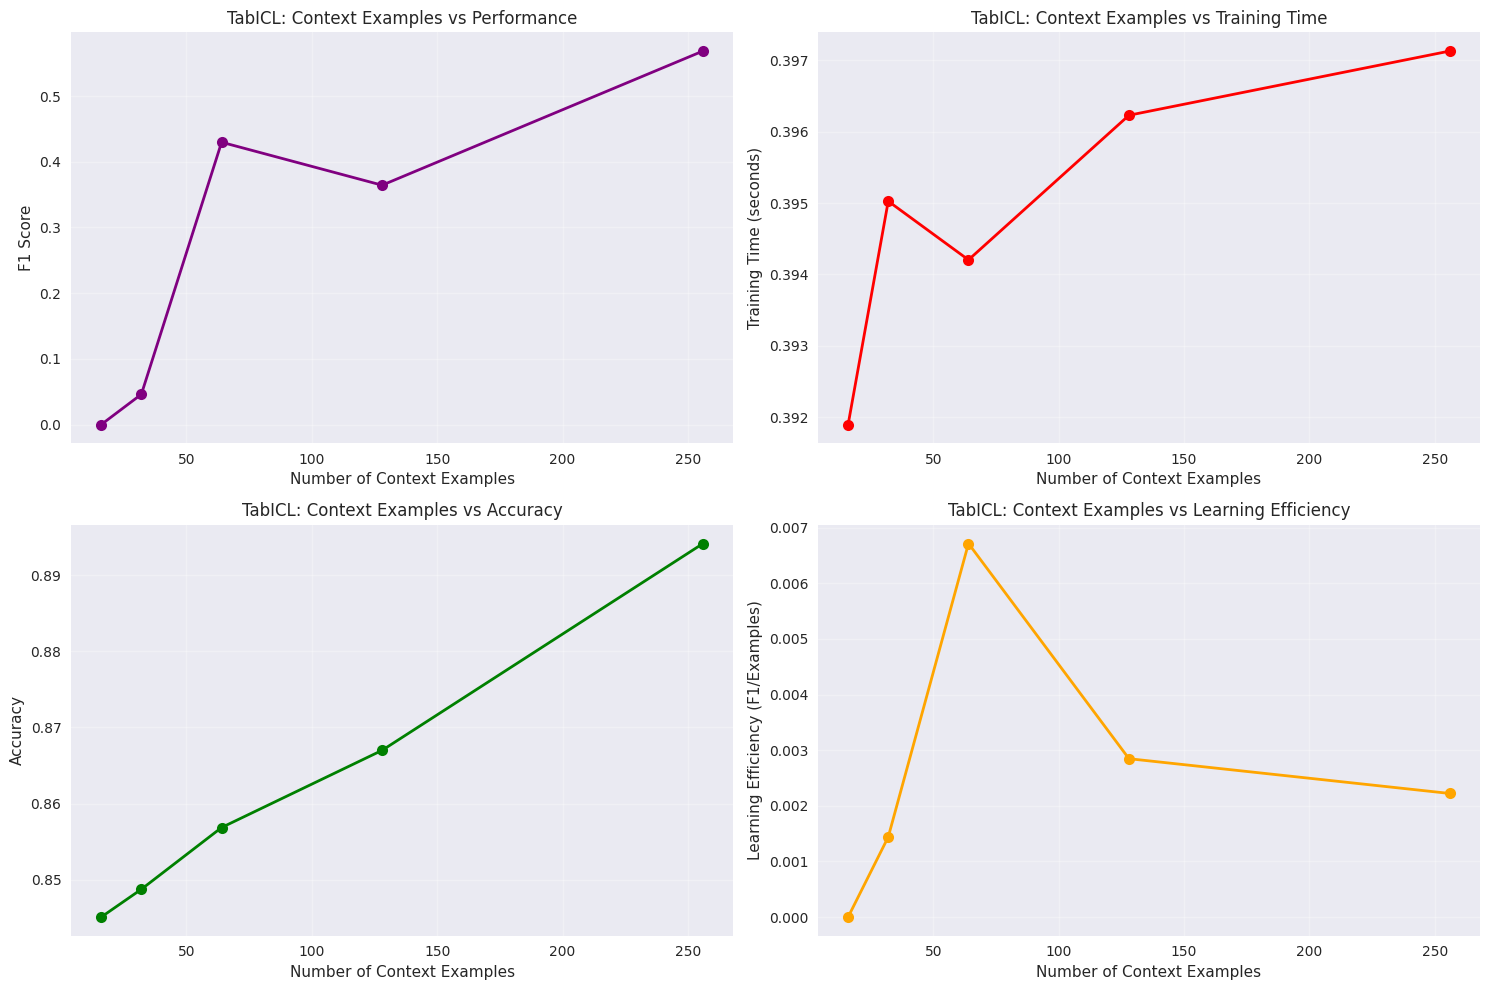


🎯 TabICL Context Examples Insights:
   Optimal for F1: 256 examples (F1: 0.5686)
   Most Efficient: 64 examples (Efficiency: 0.0067)
   Performance Range: 0.0000 - 0.5686
   Time Range: 0.39s - 0.40s


<Figure size 800x550 with 0 Axes>

In [11]:
# TabICL-specific analysis
if 'TabICL' in enhanced_ablation_results:
    tabicl_results = enhanced_ablation_results['TabICL']
    
    print("\n🎯 TABICL ENHANCED ABLATION ANALYSIS")
    print("=" * 80)
    
    # Context Examples Optimization
    if 'context_examples_ablation' in tabicl_results:
        examples_results = tabicl_results['context_examples_ablation']
        
        print("\n📝 Context Examples Optimization Results:")
        examples_df = pd.DataFrame(examples_results)
        print(examples_df.round(4).to_string())
        
        # Visualization
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Performance vs Context Examples
        ax1.plot(examples_df['context_examples'], examples_df['f1_score'], 'o-', 
                linewidth=2, markersize=8, color='purple')
        ax1.set_xlabel('Number of Context Examples')
        ax1.set_ylabel('F1 Score')
        ax1.set_title('TabICL: Context Examples vs Performance')
        ax1.grid(True, alpha=0.3)
        
        # Training Time vs Context Examples
        ax2.plot(examples_df['context_examples'], examples_df['train_time'], 'o-', 
                linewidth=2, markersize=8, color='red')
        ax2.set_xlabel('Number of Context Examples')
        ax2.set_ylabel('Training Time (seconds)')
        ax2.set_title('TabICL: Context Examples vs Training Time')
        ax2.grid(True, alpha=0.3)
        
        # Accuracy vs Context Examples
        ax3.plot(examples_df['context_examples'], examples_df['accuracy'], 'o-', 
                linewidth=2, markersize=8, color='green')
        ax3.set_xlabel('Number of Context Examples')
        ax3.set_ylabel('Accuracy')
        ax3.set_title('TabICL: Context Examples vs Accuracy')
        ax3.grid(True, alpha=0.3)
        
        # Learning Efficiency
        learning_efficiency = examples_df['f1_score'] / examples_df['context_examples']
        ax4.plot(examples_df['context_examples'], learning_efficiency, 'o-', 
                linewidth=2, markersize=8, color='orange')
        ax4.set_xlabel('Number of Context Examples')
        ax4.set_ylabel('Learning Efficiency (F1/Examples)')
        ax4.set_title('TabICL: Context Examples vs Learning Efficiency')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('TabICL_Ablation_Results.png')
        plt.show()
        
        
        # Optimal context examples analysis
        best_f1_idx = examples_df['f1_score'].idxmax()
        best_efficiency_idx = learning_efficiency.idxmax()
        
        print(f"\n🎯 TabICL Context Examples Insights:")
        print(f"   Optimal for F1: {examples_df.loc[best_f1_idx, 'context_examples']} examples (F1: {examples_df.loc[best_f1_idx, 'f1_score']:.4f})")
        print(f"   Most Efficient: {examples_df.loc[best_efficiency_idx, 'context_examples']} examples (Efficiency: {learning_efficiency.iloc[best_efficiency_idx]:.4f})")
        print(f"   Performance Range: {examples_df['f1_score'].min():.4f} - {examples_df['f1_score'].max():.4f}")
        print(f"   Time Range: {examples_df['train_time'].min():.2f}s - {examples_df['train_time'].max():.2f}s")

## Cross-Model Feature Importance Analysis

{'all_results': {'XGBoost': {'baseline': {'accuracy': 0.897404703974047, 'f1': 0.6306569343065693, 'precision': 0.7128712871287128, 'recall': 0.5654450261780105, 'auc': 0.9212499120700224, 'train_time': 0.1621854305267334, 'inference_time': 0.0038073062896728516, 'n_train_samples': 7891, 'n_test_samples': 2466}, 'feature_ablation': {'single_feature_removal': [{'removed_feature': 'PageValues', 'removed_feature_idx': 8, 'f1_score': 0.2585551330798479, 'f1_drop': 0.37210180122672143, 'relative_importance': 0.5900225320377411}, {'removed_feature': 'Month', 'removed_feature_idx': 10, 'f1_score': 0.6038291605301914, 'f1_drop': 0.026827773776377906, 'relative_importance': 0.04253940980745108}, {'removed_feature': 'Region', 'removed_feature_idx': 13, 'f1_score': 0.624277456647399, 'f1_drop': 0.006379477659170352, 'relative_importance': 0.010115606936415951}, {'removed_feature': 'TrafficType', 'removed_feature_idx': 14, 'f1_score': 0.6267806267806267, 'f1_drop': 0.0038763075259425905, 'relative

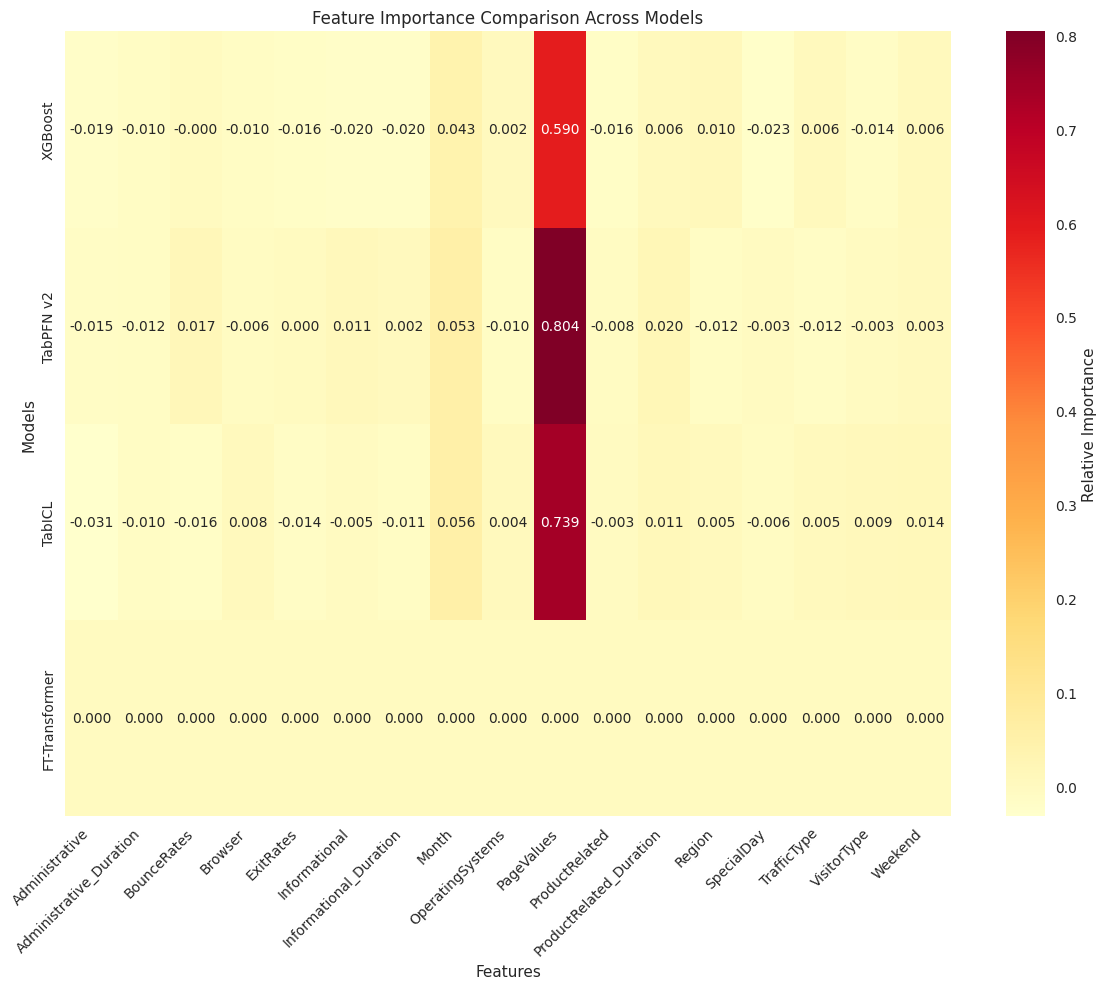


🏆 TOP FEATURES CONSENSUS:

Top 5 Most Important Features (Average Across Models):
   1. PageValues: 0.5332
   2. Month: 0.0379
   3. ProductRelated_Duration: 0.0092
   4. Weekend: 0.0056
   5. Region: 0.0008

Model Agreement on Top Features:
   XGBoost: PageValues, Month, Region
   TabPFN v2: PageValues, Month, ProductRelated_Duration
   TabICL: PageValues, Month, Weekend
   FT-Transformer: Administrative, Administrative_Duration, BounceRates


<Figure size 800x550 with 0 Axes>

In [26]:
# Cross-model feature importance comparison
#temp = {}
#filename='online_shoppers_section5_ablation_results.pkl'
#with open(filename, 'rb') as f:
#        temp = pickle.load(f)

#print(temp)
#enhanced_ablation_results = temp['all_results']
if 'comparative_analysis' in enhanced_ablation_results:
    comparative_results = enhanced_ablation_results['comparative_analysis']
    
    print("\n🎯 CROSS-MODEL FEATURE IMPORTANCE ANALYSIS")
    print("=" * 80)
    
    if 'feature_importance_comparison' in comparative_results:
        importance_comparison = comparative_results['feature_importance_comparison']
        
        # Create feature importance comparison table
        all_features = set()
        for model_importance in importance_comparison.values():
            all_features.update(model_importance.keys())
        all_features = sorted(list(all_features))
        
        importance_df = pd.DataFrame(index=all_features)
        for model_name, feature_importance in importance_comparison.items():
            importance_df[model_name] = [feature_importance.get(feature, 0) for feature in all_features]
        
        print("\nFeature Importance Comparison (Relative Importance):")
        print(importance_df.round(4).to_string())
        
        # Plot feature importance heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(importance_df.T, annot=True, fmt='.3f', cmap='YlOrRd', 
                   cbar_kws={'label': 'Relative Importance'})
        plt.title('Feature Importance Comparison Across Models')
        plt.xlabel('Features')
        plt.ylabel('Models')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('Ablation_Feature_Imp_Across_Models_Results.png')
        plt.show()
        
        
        # Top features consensus
        print("\n🏆 TOP FEATURES CONSENSUS:")
        
        # Calculate average importance across models
        avg_importance = importance_df.mean(axis=1).sort_values(ascending=False)
        
        print("\nTop 5 Most Important Features (Average Across Models):")
        for i, (feature, importance) in enumerate(avg_importance.head().items()):
            print(f"   {i+1}. {feature}: {importance:.4f}")
        
        # Model agreement analysis
        print("\nModel Agreement on Top Features:")
        for model in importance_df.columns:
            top_features = importance_df[model].nlargest(3).index.tolist()
            print(f"   {model}: {', '.join(top_features)}")